# How to pass custom run ID or set tags and metadata for graph runs in LangSmith

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://docs.smith.langchain.com">
                    LangSmith Documentation
                </a>
            </li>
            <li>
                <a href="https://smith.langchain.com">
                    LangSmith Platform
                </a>
            </li>
            <li>
                <a href="https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.config.RunnableConfig.html#langchain_core.runnables.config.RunnableConfig">
                    RunnableConfig
                </a>
            </li>
            <li>
                <a href="https://docs.smith.langchain.com/how_to_guides/tracing/trace_with_langchain#add-metadata-and-tags-to-traces">
                    Add metadata and tags to traces
                </a>                
            </li>
            <li>
                <a href="https://docs.smith.langchain.com/how_to_guides/tracing/trace_with_langchain#customize-run-name">
                    Customize run name
                </a>                
            </li>
        </ul>
    </p>
</div> 

Debugging graph runs can sometimes be difficult to do in an IDE or terminal. [LangSmith](https://docs.smith.langchain.com) lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read the [LangSmith documentation](https://docs.smith.langchain.com) for more information on how to get started.

To make it easier to identify and analyzed traces generated during graph invocation, you can set additional configuration at run time (see [RunnableConfig](https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.config.RunnableConfig.html#langchain_core.runnables.config.RunnableConfig)):

| **Field**   | **Type**            | **Description**                                                                                                    |
|-------------|---------------------|--------------------------------------------------------------------------------------------------------------------|
| run_name    | `str`               | Name for the tracer run for this call. Defaults to the name of the class.                                          |
| run_id      | `UUID`              | Unique identifier for the tracer run for this call. If not provided, a new UUID will be generated.                 |
| tags        | `List[str]`         | Tags for this call and any sub-calls (e.g., a Chain calling an LLM). You can use these to filter calls.            |
| metadata    | `Dict[str, Any]`    | Metadata for this call and any sub-calls (e.g., a Chain calling an LLM). Keys should be strings, values should be JSON-serializable. |

LangGraph graphs implement the [LangChain Runnable Interface](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.base.Runnable.html) and accept a second argument (`RunnableConfig`) in methods like `invoke`, `ainvoke`, `stream` etc.

The LangSmith platform will allow you to search and filter traces based on `run_name`, `run_id`, `tags` and `metadata`.


## TLDR

```python
import uuid
# Generate a random UUID -- it must be a UUID
config = {"run_id": uuid.uuid4()}, "tags": ["my_tag1"], "metadata": {"a": 5}}
# Works with all standard Runnable methods 
# like invoke, batch, ainvoke, astream_events etc
graph.stream(inputs, config, stream_mode="values")
```

The rest of the how to guide will show a full agent.

## Setup

First, let's install the required packages and set our API keys

In [28]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

In [29]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define the graph

For this example we will use the [prebuilt ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/).

In [26]:
from langchain_openai import ChatOpenAI
from typing import Literal
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

# First we initialize the model we want to use.
model = ChatOpenAI(model="gpt-4o", temperature=0)


# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)
@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]


# Define the graph
graph = create_react_agent(model, tools=tools)

## Run your graph

Now that we've defined our graph let's run it once and view the trace in LangSmith. In order for our trace to be easily accessible in LangSmith, we will pass in a custom `run_id` in the config.

This assumes that you have set your `LANGSMITH_API_KEY` environment variable.

Note that you can also configure what project to trace to by setting the `LANGCHAIN_PROJECT` environment variable, by default runs will be traced to the `default` project.

In [27]:
import uuid


def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "what is the weather in sf")]}

config = {"run_name": "agent_007", "tags": ["cats are awesome"]}

print_stream(graph.stream(inputs, config, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_9ZudXyMAdlUjptq9oMGtQo8o)
 Call ID: call_9ZudXyMAdlUjptq9oMGtQo8o
  Args:
    city: sf
================================= Tool Message =================================
Name: get_weather

It's always sunny in sf
================================== Ai Message ==================================

The weather in San Francisco is currently sunny.


## View the trace in LangSmith

Now that we've ran our graph, let's head over to LangSmith and view our trace. First click into the project that you traced to (in our case the default project). You should see a run with the custom run name "agent_007".

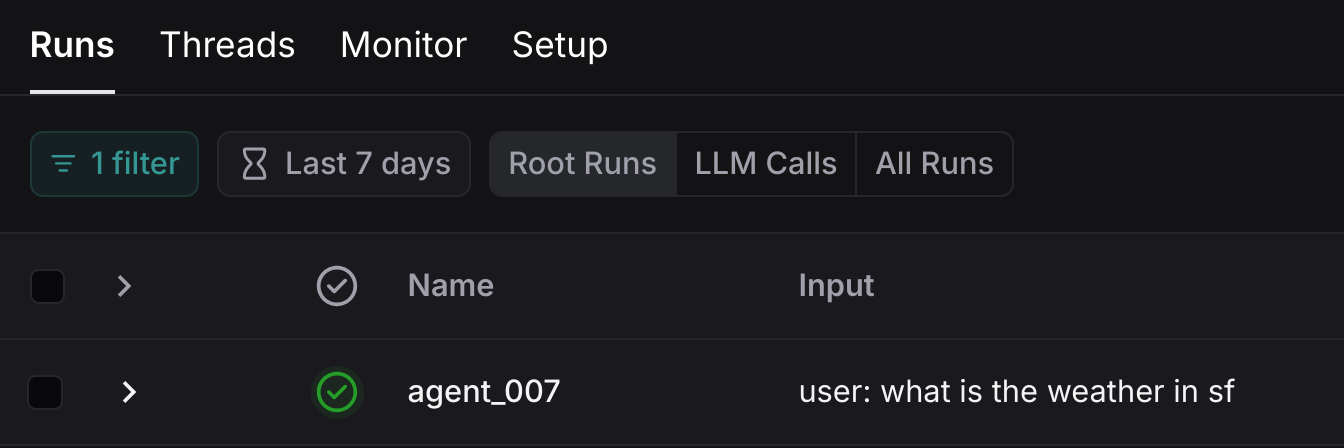

In addition, you will be able to filter traces after the fact using the tags or metadata provided. For example,

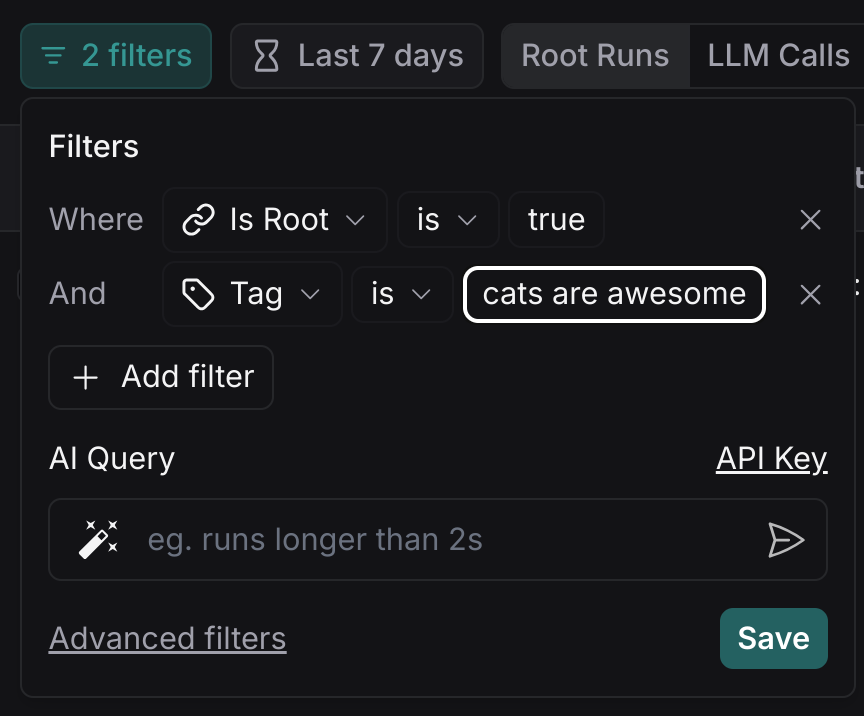
